# (2) Calculation of the fluorescence per molecule and the exponential growth rate - $37^\circ$C.

In this worksheet we estimate the exponential growth rate for each generation in each lineage, as well as the proportionality constant between the fluorescence and `molecule #` for each lineage.

We first import the data from the $37^\circ$C dataset.

In [1]:
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(filelist)
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

Let's have a look at the first few rows of data for the first cell lineage. Note the second column is the division indicator and is equal to 1 if the cell has divided most recently at that time point and 0 otherwise.

In [3]:
first_few_rows = raw_data[1][1:34,:]; # first 34 timepoints of lineage 1 data.
display(first_few_rows)

34×5 Array{Float64,2}:
  1.0  1.0  2.09708  338326.0  5546.33
  2.0  0.0  2.10993  344303.0  5553.27
  3.0  0.0  2.29029  370118.0  5442.91
  4.0  0.0  2.47987  405355.0  5629.93
  5.0  0.0  2.39596  381219.0  5689.84
  6.0  0.0  2.46906  387991.0  5542.73
  7.0  0.0  2.49225  415390.0  5690.27
  8.0  0.0  2.49002  414404.0  5676.77
  9.0  0.0  2.54599  435754.0  5733.61
 10.0  0.0  2.54237  430027.0  5811.18
 11.0  0.0  2.65326  438526.0  5695.14
 12.0  0.0  2.64758  436573.0  5669.78
 13.0  0.0  2.72036  472680.0  5764.39
  ⋮                            
 23.0  0.0  3.52673  614441.0  5689.27
 24.0  0.0  3.65501  616226.0  5653.45
 25.0  0.0  3.73755  657481.0  5767.38
 26.0  0.0  3.81613  662422.0  5710.53
 27.0  0.0  3.96744  661705.0  5961.31
 28.0  0.0  4.13382  716700.0  5643.31
 29.0  0.0  4.23825  726548.0  5906.89
 30.0  0.0  4.30962  733140.0  5960.49
 31.0  0.0  4.50653  772114.0  5894.0
 32.0  0.0  4.69967  798307.0  5827.06
 33.0  0.0  4.73342  796625.0  5944.96
 34.0  1.0

We observe that the first division of the cell occurs at *t=34*. Now for the calculation of the proportionality between molecule number and fluorescence, and the exponential growth rate, we need to separate the fluorescence data for each lineage into cell-cycle generations. Let's do this:

In [4]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # the fluor. data for each lineage.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # the fluor. data for each lineage.
times_all_lins = [raw_data[x][:,1] for x in 1:length(raw_data)]; # the fluor. data for each lineage.
div_flag_all_lins = [raw_data[x][:,2] for x in 1:length(raw_data)]; # the division flag data for each lineage.
# now need to loop over all lineages and find the indices where division occurs.
div_times = [findall(y-> y == 1.0, div_flag_all_lins[x]) for x in 1:length(div_flag_all_lins)]

# for each lineage i div_times[i] contains the times of division.
# Now need to form the 3-d array containing the separated generations for each lineage.

fluor_sep_all_lins = []; # 3-d array to contain all generation array for each lineage for fluor.
vol_sep_all_lins = []; # 3-d array to contain all generation array for each lineage for vol.
time_sep_all_lins = [];

for x in 1:length(fluor_all_lins)
    gens = [];
    gens_vol = []; 
    gens_time = [];
    
    fluor_lin = fluor_all_lins[x];
    vol_lin = vol_all_lins[x];
    times_lin = times_all_lins[x]
    
    dt_lin = div_times[x];
    for y in 1:length(dt_lin)
        if y < length(dt_lin)
            push!(gens,fluor_lin[dt_lin[y]:dt_lin[y+1]-1]);
            push!(gens_vol,vol_lin[dt_lin[y]:dt_lin[y+1]-1]);
            push!(gens_time,times_lin[dt_lin[y]:dt_lin[y+1]-1]);
        else
            push!(gens,fluor_lin[dt_lin[y]:length(fluor_lin)]);
            push!(gens_vol,vol_lin[dt_lin[y]:length(fluor_lin)]);
            push!(gens_time,times_lin[dt_lin[y]:length(fluor_lin)]);
        end
    end
    push!(fluor_sep_all_lins,gens);
    push!(vol_sep_all_lins,gens_vol);
    push!(time_sep_all_lins,gens_time);
end

- `fluor_sep_all_lins[1]` gives the 2-d array for each lineage which contains the 1-d arrays for each generation.
- `fluor_sep_all_lins[1][1]` gives the 1-d fluorescence array for generation 1 in lineage 1.

Let's form a generic method to extract the generations for data of each type (e.g., fluroescence, volume etc.). We can then save this as a module to use with ease in later notebooks. The inputs will be:

- (1) `dat_arr`: the 2-d array of Tanouchi data formated as above.
- (2) `col`: the column of data one wishes to extract.

In [5]:
"""
function extract_gens(dat_arr,col::Int)
    all_lins_data = [dat_arr[x][:,col] for x in 1:length(dat_arr)]; # extract the column of interest.
    div_flag_all_lins = [dat_arr[x][:,2] for x in 1:length(dat_arr)]; # the division flag data for each lineage.
    
    # now need to loop over all lineages and find the indices where division occurs.
    div_times = [findall(y-> y == 1.0, div_flag_all_lins[x]) for x in 1:length(div_flag_all_lins)];
    
    # init the 3-d generation sep data array.
    gen_sep_lins = [];
    
    # start loop over all lineages.    
    for x in 1:length(all_lins_data)
        gens = []; # init the 2-d generation measurements array.
        lin_data = all_lins_data[x]; # take the data for that lin.
        dt_lin = div_times[x]; # find the division times for that lin and then loop over.
        for y in 1:length(dt_lin)
            if y < length(dt_lin)
                push!(gens,lin_data[dt_lin[y]:dt_lin[y+1]-1]);
            else
                continue
            end
        end
        push!(gen_sep_lins,gens);
    end
    
    return gen_sep_lins
end
"""

"function extract_gens(dat_arr,col::Int)\n    all_lins_data = [dat_arr[x][:,col] for x in 1:length(dat_arr)]; # extract the column of interest.\n    div_flag_all_lins = [dat_arr[x][:,2] for x in 1:length(dat_arr)]; # the division flag data for each lineage.\n    \n    # now need to loop over all lineages and find the indices where division occurs.\n    div_times = [findall(y-> y == 1.0, div_flag_all_lins[x]) for x in 1:length(div_flag_all_lins)];\n    \n    # init the 3-d generation sep data array.\n    gen_sep_lins = [];\n    \n    # start loop over all lineages.    \n    for x in 1:length(all_lins_data)\n        gens = []; # init the 2-d generation measurements array.\n        lin_data = all_lins_data[x]; # take the data for that lin.\n        dt_lin = div_times[x]; # find the division times for that lin and then loop over.\n        for y in 1:length(dt_lin)\n            if y < length(dt_lin)\n                push!(gens,lin_data[dt_lin[y]:dt_lin[y+1]-1]);\n            else\n         

Test this function to extract the fluorescence.

In [6]:
include("./extract_gens.jl"); using .extract;

In [7]:
test = extract_gens(raw_data,4);
test[1]; # show for the first gen.

## Calculating the Exponential growth rate for each generation

Now that we have separated each lineage into its respective generations let's estimate the exponential growth rate in each generation. We start by creating a model to fit to the volume for each generation. We will use the LsqFit.jl package.

In [8]:
using LsqFit

This is an example of how the fitting program works here. We specifiy the model with the params `p` to be selected by minimising the model to the data. This below finds the initial vol and the exp growth rate as via the least squares fitting procedure for generation 1 in lineage 1. Note that the units of the `p[1]` volume param are $\mu$m (volume $\propto$ length) and the units of the `p[2]` volume param for exponential growth rate are min$^{-1}$.

In [9]:
m(t,p) = 10^p[1] * exp.(10^p[2] * t);
p0 = [-0.3,-2.0]
t_data = time_sep_all_lins[1][10]
fit = 10^curve_fit(m,t_data,vol_sep_all_lins[1][10],p0).param[2]

0.02760090975872231

We now extend this fitting procedure for all the generations in the first two lineages. Note that in an additional worksheet (2.5) we do this for all generations of all lineages and save the result. We do only the first two lineages to save computational time in the evaluation of the worksheet.

In [10]:
exp_grs = []; # init. 3-d array to store the models for each gen of each lin.
for x in 1:length(vol_sep_all_lins[1:2]) # loop over lins - do for first 2. 
    gens = [];
    lin_vols_x = vol_sep_all_lins[x] # 2-d array of gen vols for lin x.
    for y in 1:length(lin_vols_x) # loop over gens in lin x.
        m(t,p) = 10^p[1] * exp.(10^p[2] * t); # create the model.
        p0 = [-0.3,-2.0]; # initial search for params V0 = 2, exp_gr = 0.02.
        t_data = time_sep_all_lins[x][y] # take the time over which the vols were obtained.
        exp_gr = 10^curve_fit(m,t_data,lin_vols_x[y],p0).param[2] # collect the exp growth param.
        push!(gens,exp_gr)
    end
    push!(exp_grs,gens)
end

Let's look at the histograms of the growth rates for the first two lineages.

In [11]:
using PyPlot; using LaTeXStrings;

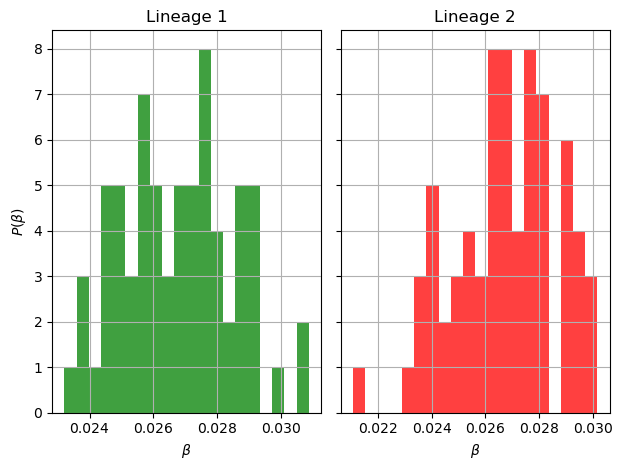

In [12]:
fig, axs = PyPlot.subplots(1, 2, sharey = true, tight_layout = true);
n_bins = 20;
axs[1].set_xlabel(L"\beta");axs[2].set_xlabel(L"\beta"); axs[1].set_ylabel(L"P(\beta)"); axs[1].set_title("Lineage 1"); axs[2].set_title("Lineage 2");axs[1].grid(true);axs[2].grid(true)
axs[1].hist(exp_grs[1], bins=n_bins, facecolor= "g", alpha=0.75);
axs[2].hist(exp_grs[2], bins=n_bins, facecolor= "r", alpha=0.75);

In a separate worksheet we have performed the calculation for all generations in all lineages and saved the result to "exp_grs_all.csv". We did this in Mathematica since its function `NonLinearModelFit` in fitting parameters is much faster than the `LsqFit` package used in Julia above.

## Calculation of proportionality for each lineage and molecule number

First we need to collect the array of fluorescence measurements at the end and start of each generation in each lineage. Once these have been found one can output the proportionality $\kappa$ (i.e., the fluorescence per molecule) given by: 
$$\kappa = 2\gamma_a - \gamma_b, $$
where $\gamma_a$ and $\gamma_b$ are the Fano factors before and after cell division respectively. One would think this must be done for each lineage...

In [13]:
using Statistics;

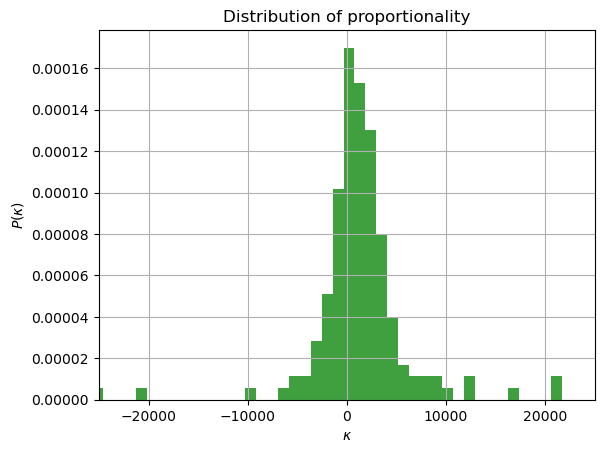

In [14]:
prop_consts = []; # array containing the prop. for each lineage.
fs_bs = [];
fs_as = [];
for x in 1:length(fluor_sep_all_lins)
    lin_fluor = fluor_sep_all_lins[x];
    fs_b = [lin_fluor[y][end] for y in 1:(length(lin_fluor)-1)]; # fluor's from before.
    fs_a = [lin_fluor[y+1][1] for y in 1:(length(lin_fluor)-1)]; # flour's from after.
    ffs_b = var(fs_b)/mean(fs_b); ffs_a = var(fs_a)/mean(fs_a);
    props = 2*ffs_a - ffs_b;
    append!(prop_consts, props); append!(fs_bs, ffs_b); append!(fs_as, ffs_a);
end

n_bins = floor(Int64,length(prop_consts));
PyPlot.xlabel(L"\kappa");
PyPlot.ylabel(L"P(\kappa)");
PyPlot.grid(true)
PyPlot.title("Distribution of proportionality")
PyPlot.xlim(-25000,25000)
PyPlot.hist(prop_consts, bins=n_bins, facecolor="g", alpha=0.75, density = true);

However, what we see is that on each lineage there is not enough information to get reasonable estimates for the fluorescence per molecule on each lineage - hence we will find the fluorescence per molecule for the whole 37$^{\circ}$C dataset.

In [15]:
fs_bs = convert(Array{Float64,1},fs_bs); fs_as = convert(Array{Float64,1},fs_as);
m(t, p) = p[1].*t .+ p[2]; p0 = [0.5, 0.9];
fit = curve_fit(m, fs_bs, fs_as, p0).param

2-element Array{Float64,1}:
    0.20184423806935956
 6185.1225536609745

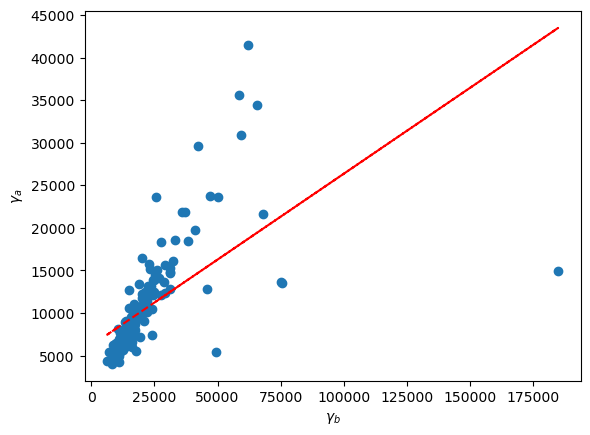

In [16]:
PyPlot.scatter(fs_bs, fs_as); PyPlot.xlabel(L"\gamma_b"); PyPlot.ylabel(L"\gamma_a");
PyPlot.plot(fs_bs, fit[1].*fs_bs .+ fit[2], "r--");

In principle the y-intercept of this best fit graph should be proportional to the fluorescence per molecule since the above plots the equation $\gamma_a = \frac{\gamma_b}{2}+\frac{\beta}{2}$. However, we see that the outliers skew the slope of the best fit line to 0.201 instead of the required 0.5. Hence we must remove these outliers.

In [17]:
new_fs_bs = []; new_fs_as = [];
for (i,f) in enumerate(fs_bs)
    if fs_bs[i] > 40000 && fs_as[i] < 15000
        continue
    else
        append!(new_fs_bs, fs_bs[i]); append!(new_fs_as, fs_as[i]);
    end
end

In [18]:
fs_bs = convert(Array{Float64,1},fs_bs); fs_as = convert(Array{Float64,1},fs_as);
m(t, p) = p[1].*t .+ p[2]; p0 = [0.5, 0.9];
fit = curve_fit(m, new_fs_bs, new_fs_as, p0).param

2-element Array{Float64,1}:
   0.5100193412581755
 554.3275406939185

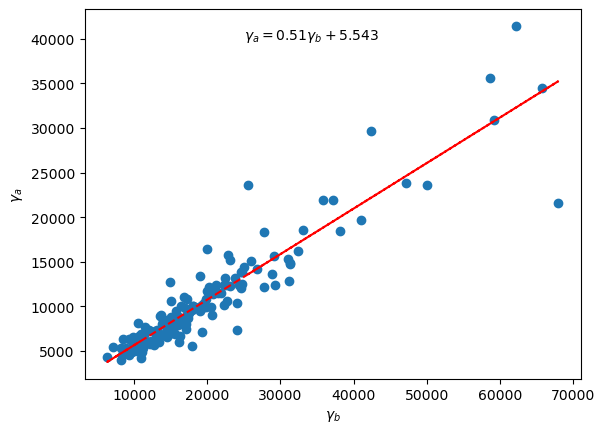

PyObject Text(25000, 40000, '$\\gamma_a = 0.51\\gamma_b + 5.543$')

In [19]:
PyPlot.scatter(new_fs_bs, new_fs_as); PyPlot.xlabel(L"\gamma_b"); PyPlot.ylabel(L"\gamma_a");
PyPlot.plot(new_fs_bs, fit[1].*new_fs_bs .+ fit[2], "r--"); PyPlot.text(25000,40000, L"\gamma_a = 0.51\gamma_b + 5.543")

Hence we find the fluorescence per molecule as:

In [20]:
fpm = 2*fit[2]

1108.655081387837

Now let's calculate the molecule number arrays for each generation in each lineage using these proportionality constants.

In [21]:
using Base.Iterators, LaTeXStrings, PyPlot;

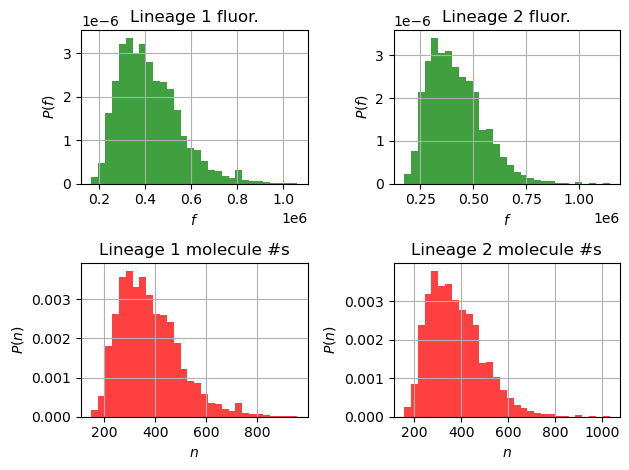

In [22]:
num_sep_all_lins = fluor_sep_all_lins./fpm;

fig, axs = PyPlot.subplots(2, 2, tight_layout = true);
n_bins = 30;

axs[1].set_xlabel(L"f");axs[2].set_xlabel(L"n"); axs[1].set_ylabel(L"P(f)"); axs[2].set_ylabel(L"P(n)"); axs[1].set_title("Lineage 1 fluor."); axs[2].set_title("Lineage 1 molecule #s");axs[1].grid(true);axs[2].grid(true)
axs[3].set_xlabel(L"f");axs[4].set_xlabel(L"n"); axs[3].set_ylabel(L"P(f)"); axs[4].set_ylabel(L"P(n)"); axs[3].set_title("Lineage 2 fluor."); axs[4].set_title("Lineage 2 molecule #s");axs[3].grid(true);axs[4].grid(true)

axs[1].hist(reduce(vcat,fluor_all_lins[1]), bins=n_bins, facecolor= "g", alpha=0.75, density = true);
axs[2].hist(reduce(vcat,num_sep_all_lins[1]), bins=n_bins, facecolor= "r", alpha=0.75, density = true);
axs[3].hist(reduce(vcat,fluor_all_lins[2]), bins=n_bins, facecolor= "g", alpha=0.75, density = true);
axs[4].hist(reduce(vcat,num_sep_all_lins[2]), bins=n_bins, facecolor= "r", alpha=0.75, density = true);

In [23]:
findfirst(x -> x > 150000, prop_consts) # find lineage with oddly high fluor. Plot below.

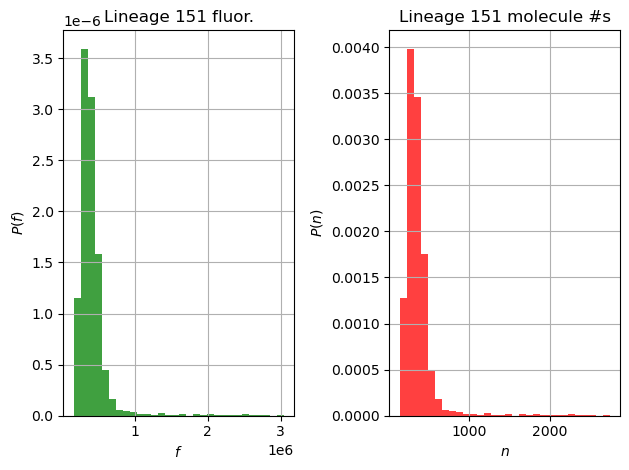

In [24]:
fig, axs = PyPlot.subplots(1, 2, tight_layout = true);

axs[1].set_xlabel(L"f");axs[2].set_xlabel(L"n"); axs[1].set_ylabel(L"P(f)"); axs[2].set_ylabel(L"P(n)"); axs[1].set_title("Lineage 151 fluor."); axs[2].set_title("Lineage 151 molecule #s");axs[1].grid(true);axs[2].grid(true);

axs[1].hist(reduce(vcat,fluor_all_lins[151]), bins=n_bins, facecolor= "g", alpha=0.75, density = true);
axs[2].hist(reduce(vcat,num_sep_all_lins[151]), bins=n_bins, facecolor= "r", alpha=0.75, density = true);

For this lineage in particular we see that the large value for the proportionality constant is due to a few very high finds in the fluorescence across the lineage.

Now let's the fluorescence per molecule proportionality in a file so that we can use it later on.

In [26]:
writedlm("MN_props.csv", fpm)